# Olivine Diffusion - 1

(c) Charles Le Losq

Olivine is one of the most important mineral composition of the upper mantle. It controls its rheology as well as seismic and eletric properties. Several studies pointed the role of water on the properties of olivine, and, hence, on those of the mantle. Despite such importance, it turns out that we do not have a consensus on the way water is stored and diffuse in olivine, as this is a very complex process.

Water diffusion in olivine seems to be linked to its diffusion in various point defects, namely Si and Mg vacancies as well as in Mg vacancies in association with trivalent cations like Al$^{3+}$ or Fe$^{3+}$, or forming a Ti-clinohumite like point defect.

In this notebook, we will see if we can see such association in a forsterite crystal that has been hydroxylated during an experiment in a piston-cylinder. The experiment lasted 48 hours at 1400 °C and 1.5 GPa. How water diffuses in those conditions in the Fo crystal ?

**This is a real worl problem, published in**

*C. Le Losq, M. C. Jollands, P. M. E. Tollan, R. Hawkins, H. St. C. O’Neill, Point defect populations of forsterite revealed by two-stage metastable hydroxylation experiments. Contrib Mineral Petrol. 174, 53 (2019).*


# Diffusion in olivine

We can study this question as a pseudo-equilibrium is rapidly established at the boundary of our olivine crystal, imposing a concentration $c_0$ at the boundary (faces of our crystal, a cube of 1x1x1 mm)

To study the diffusive process, we can use the Fick equations. In particular, the second law of Fick allows describing the variation of the concentration of a substance in a media given time. In one dimension, we have:

$ \frac{\partial c}{\partial t} $ = D $ \frac{\partial^2 c }{\partial x^2} $ .   (eq. 1)

Assuming a constant concentration $c_0$ at $x$ = 0, a simple solution is given by : 

$ c(x,t) = c_0 \text{erfc}({\frac{x}{2\sqrt{Dt}}})$ . (eq. 2)

Represent below the profil of concentration at t = 0 h, t = 12 h, t = 24 h and t = 48 h.

*Tips: (1) erfc function is provided by scipy.special; (2) t=0 does not work, but you can use t=0.000001 as an approximation.*

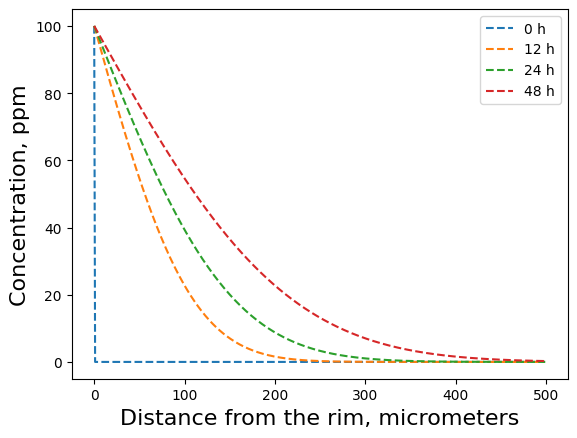

In [7]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(42)
import pandas as pd
import scipy
from scipy.optimize import curve_fit

from scipy.special import erfc

def diff(x,t,D,c0):
    """1D solution to Fick second law
    
    Parameters
    ----------
    x : distance in microns
    
    t : time in h
    
    D : diffusion coefficient in log10 m2 s-1
    
    c0 : concentration at the border in ppm
    
    Returns
    -------
    c : concentration at distance x
    """
    return c0*erfc(x*1e-6/(2*np.sqrt(10**D*t*3600)))

x = np.arange(0,500,1.0) # Notre profil de la bordure au centre

x0 = 100.0 # ppm, la concentration en eau à la bordure

D = -13.1 # m2 s-1, le coefficient de diffusion à la température de travail, 1400 °C

plt.plot(x, diff(x,0.00001,D,100.0),"--",label="0 h")
plt.plot(x, diff(x,12,D,100.0),"--",label="12 h")
plt.plot(x, diff(x,24,D,100.0),"--",label="24 h")
plt.plot(x, diff(x,48,D,100.0),"--",label="48 h")
plt.xlabel("Distance from the rim, micrometers",fontsize=16)
plt.ylabel("Concentration, ppm",fontsize=16)
plt.legend()

# Application to real-world data

You will find two files with concentrations in Al, Fe, Sc... measured by LA-ICP-MS after one experiments. Conditions are in the filename.

Your ultimate goal is to : 
- fit those data and determine the diffusion coefficients of those elements; 
- provide sensible errors bars for the parameters, and propagate them on the fit solution;
- Re-do the above graph for all elements with errors bars

Index(['ElapsedTime_s', 'Distance', 'Si29_CPS', 'Mg_ppm_m25', 'Al_ppm_m27',
       'Sc_ppm_m45', 'Ti_ppm_m47', 'Fe_ppm_m57', 'Re_ppm_m185', 'Pt_ppm_m195'],
      dtype='object')
Index(['ElapsedTime_s', 'Distance', 'Si29_CPS', 'Mg_ppm_m25', 'Al_ppm_m27',
       'Sc_ppm_m45', 'Ti_ppm_m47', 'Fe_ppm_m57', 'Re_ppm_m185', 'Pt_ppm_m195'],
      dtype='object')


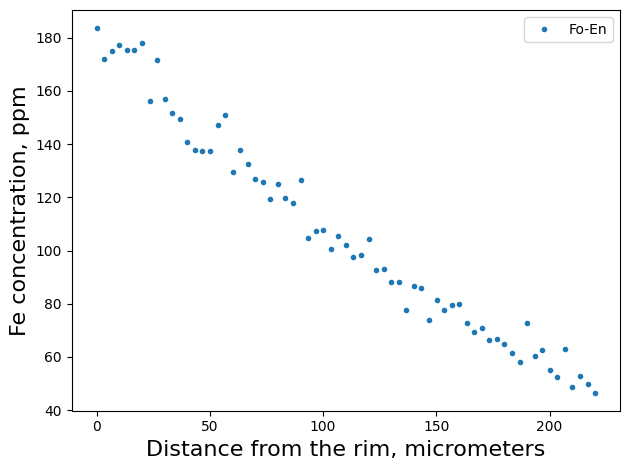

In [ ]:
#
# Loading the data
#
data_1400C_192h_FoEn = pd.read_csv("./data/16C_ICP1_1400C_axisC_192h_FoEn.csv")
print(data_1400C_192h_FoEn.columns)
data_1400C_192h_FoPer = pd.read_csv("./data/16B_ICP2_1400C_axisC_192h_FoPer.csv")
print(data_1400C_192h_FoPer.columns)

#
# The data we want to fit
#
t_exp = 192.0*3600
x_obs_1 = data_1400C_192h_FoEn.Distance.values
y_obs_1 = data_1400C_192h_FoEn.Fe_ppm_m57.values
ese_obs_1 = 7.0*np.ones(len(x_obs_1))

#
# Plotting my data
#
plt.plot(x_obs_1,y_obs_1,".",label="Fo-En")
plt.xlabel("Distance from the rim, micrometers",fontsize=16)
plt.ylabel("Fe concentration, ppm",fontsize=16)
plt.legend()
plt.tight_layout()

# Problem resolution

## Forward model (eq. 1)

$$ C(x) = C(0) \times erfc(\frac{x}{2\sqrt{Dt}})$$

Do not forget to scale things !

    - D in log10
    - x in micrometers, so multiply by 1e-6 in the function

In [12]:
def forward_model(x, D, c0):
    """This is the foward model: solution in 1D of Fick diffusion
    
    Parameters
    ----------
    x : 1d array
        the distance in microns
    D : float
        the diffusion coefficient, in log10 m2 s-1
    c0 : float
        the concentration at the border
        
    Returns
    -------
    c(x) : array
        the array of the concentrations at x
    """
    t = 192.0*3600 # time is defined here
    return c0*erfc(x*1e-6/(2*np.sqrt(10**D*t)))

## How does this problem behave? How far from the ground truth a model can be?

To answer those questions and quantify this, we can generate synthetic data and fit them. We need to understand our problem before trying to solve it. The best way to do that is to work on synthetic data. We will simulate a diffusive process occuring in 192 h.

Let's do that in the following cells:

Text(0, 0.5, 'Fe concentration, ppm')

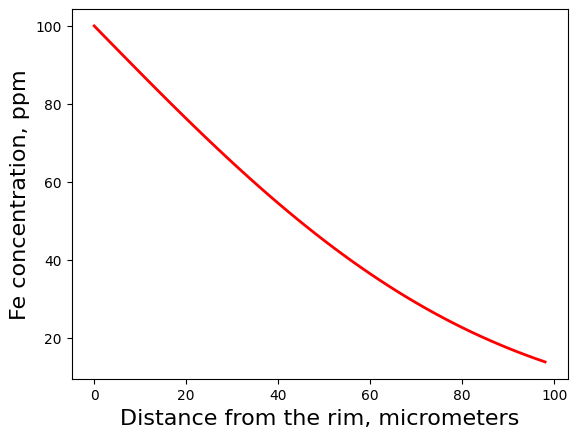

In [15]:
x_synthetic = np.arange(0, 100,  2.0) # microns
D_synthetic = -14.5 # log10 m2 s-1
c0_synthetic = 100.0 # ppm

y_synthetic = forward_model(x_synthetic, D_synthetic, c0_synthetic)

plt.figure()
plt.plot(x_synthetic, y_synthetic, "r-", linewidth=2.0, label="ground truth")

plt.xlabel("Distance from the rim, micrometers",fontsize=16)
plt.ylabel("Fe concentration, ppm",fontsize=16)

Real world data are noisy. Let's reproduce this by adding noise.

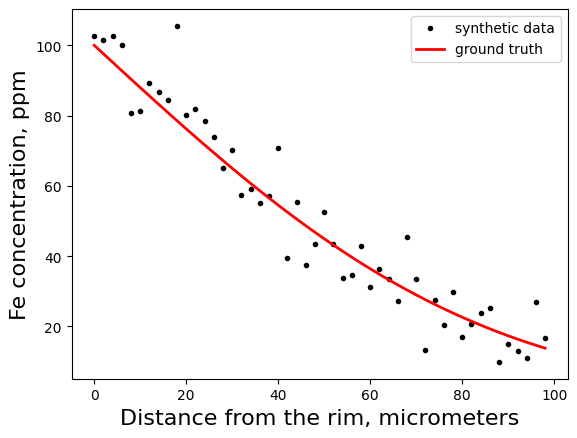

In [16]:
# Gaussian-distributed noise (best case scenario actually)
noise_synthetic = np.random.randn(len(x_synthetic))*7.0
y_synthetic_noisy = y_synthetic + noise_synthetic
# the following line is to associate each y value with its absolute sigma value
noise_synthetic = np.abs(noise_synthetic)

# we replot the noisy data
plt.figure()
plt.plot(x_synthetic,y_synthetic_noisy,"k.",label="synthetic data")
plt.plot(x_synthetic, y_synthetic, "r-", linewidth=2.0, label="ground truth")

plt.xlabel("Distance from the rim, micrometers",fontsize=16)
plt.ylabel("Fe concentration, ppm",fontsize=16)
plt.legend(loc="best")

# Fitting the data

We can guess look at the figure that the data follow some second order polynomial, or maybe a third. Simplicity is great, so we chose a second order polynomial.

The idea is now to define a model *m* which fits our data *d* with some parameters we can tune. We basically want to map:

$d = g(m)$ , eq. 2

with $g$ the mapping function and $m$ the model (set of model parameters). In this case, $g$ is equation 1 (see above) and $m$ are the $D$ and $c0$ parameters.

An easy and well used way to fit our data with eq. 2 is to use **least-square regression**.

The least-square problem consists in minimizing the misfit between the observation $d$ and the model predictions $g(m)$:

$misfit = \sum_{i=1}^{n}{(d_i-g_i(m))^2}$ , eq. 3

We want to minimize this value. Eq. 3 is called the **objective function** or **misfit function** of our problem. Eq. 3 is a least-square objective function. Other functions can be used, like the least absolute value objective function (a.k.a. L1 norm).

There is several way to do that. In python, one of the simplest is to **use the curve_fit function of scipy**. In order to use this function, we need to have another one that allows calculating eq. 1. Let's do that.

/var/folders/23/p99d2kmd0vlg5qrqb4vq2q840000gn/T/ipykernel_66387/631732092.py:19: RuntimeWarning: divide by zero encountered in divide
  return c0*erfc(x*1e-6/(2*np.sqrt(10**D*t)))
/var/folders/23/p99d2kmd0vlg5qrqb4vq2q840000gn/T/ipykernel_66387/631732092.py:19: RuntimeWarning: invalid value encountered in divide
  return c0*erfc(x*1e-6/(2*np.sqrt(10**D*t)))
/var/folders/23/p99d2kmd0vlg5qrqb4vq2q840000gn/T/ipykernel_66387/631732092.py:19: RuntimeWarning: overflow encountered in scalar power
  return c0*erfc(x*1e-6/(2*np.sqrt(10**D*t)))
/var/folders/23/p99d2kmd0vlg5qrqb4vq2q840000gn/T/ipykernel_66387/2318752252.py:4: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(forward_model, x_synthetic, y_synthetic_noisy)
/var/folders/23/p99d2kmd0vlg5qrqb4vq2q840000gn/T/ipykernel_66387/2318752252.py:5: OptimizeWarning: Covariance of the parameters could not be estimated
  popt2, pcov2 = curve_fit(forward_model, x_synthetic, y_synthetic_noisy,


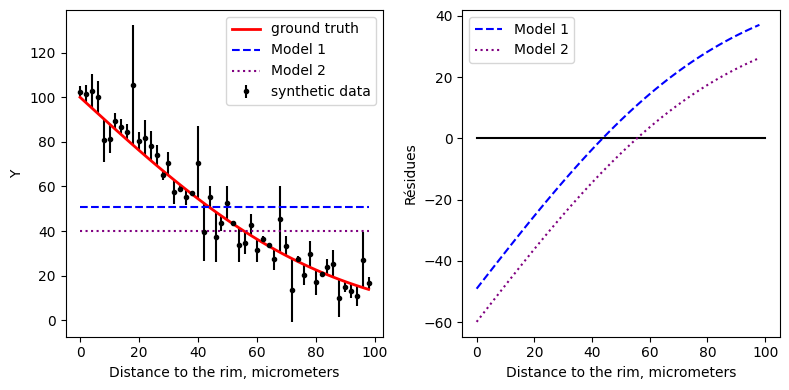

In [17]:
# we need to import curve_fit for fitting our curve
# we also import uncertainties for error propagation
from scipy.optimize import curve_fit 
popt, pcov = curve_fit(forward_model, x_synthetic, y_synthetic_noisy)
popt2, pcov2 = curve_fit(forward_model, x_synthetic, y_synthetic_noisy, 
                         sigma=noise_synthetic, 
                         absolute_sigma=True)

plt.figure(figsize=(8,4))

plt.subplot(1,2,1)

plt.errorbar(x_synthetic,y_synthetic_noisy,
             yerr=noise_synthetic,
             fmt=".", color="k",label="synthetic data")
plt.plot(x_synthetic, y_synthetic, "r-", linewidth=2.0, label="ground truth")
plt.plot(x_synthetic,forward_model(x_synthetic, *popt),"b--",label="Model 1")
plt.plot(x_synthetic,forward_model(x_synthetic, *popt2),":",c="purple",label="Model 2")
plt.xlabel("Distance to the rim, micrometers")
plt.ylabel("Y")
plt.legend()

plt.subplot(1,2,2)
plt.plot([0,100],[0,0],"k")
plt.plot(x_synthetic,forward_model(x_synthetic, *popt)-y_synthetic,"b--",label="Model 1")
plt.plot(x_synthetic,forward_model(x_synthetic, *popt2)-y_synthetic,":",c="purple",label="Model 2")
plt.ylabel("Résidues")
plt.xlabel("Distance to the rim, micrometers")
plt.legend()

plt.tight_layout()

Hum... It does not work... Why?

`curve_fit` actually uses a local least square algorithm... Let's have a look at the objective space. Time to swith to the notebook 03_OlivineDiffusion_2 ! 